In [1]:
from copy import deepcopy
from time import time

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import pytreenet as ptn

In [2]:
def create_ttns(bond_dim: int) -> ptn.TreeTensorNetworkState:

    zero_state = np.asarray([1, 0])
    end_tensor = zero_state.reshape(1,2)
    end_tensor = np.pad(end_tensor, ((0, bond_dim-1), (0, 0)))
    chain_tensor = zero_state.reshape(1,1,2)
    chain_tensor = np.pad(chain_tensor, ((0, bond_dim-1),(0, bond_dim-1),(0, 0)))
    # center_tensor = zero_state.reshape(1,1,1,2)
    center_tensor =  np.asarray([1]).reshape(1,1,1,1)
    center_tensor = np.pad(center_tensor, ((0, bond_dim-1),(0, bond_dim-1),(0, bond_dim-1),(0, 0)))
    ttns = ptn.TreeTensorNetworkState()
    center_node = ptn.Node(identifier="center")
    ttns.add_root(center_node, center_tensor)
    for i in range(3):
        chain_node = ptn.Node(identifier=f"chain_{i}")
        ttns.add_child_to_parent(chain_node, deepcopy(chain_tensor),
                                 0,"center",i)
        end_node = ptn.Node(identifier=f"end_{i}")
        ttns.add_child_to_parent(end_node, deepcopy(end_tensor),
                                 0,f"chain_{i}",1)
    return ttns

In [3]:
def create_problem_hamiltonian(ttn: ptn.TreeStructure, g: float) -> ptn.TTNO:
    X, _ , Z = ptn.pauli_matrices()
    # nn_hamiltonian = ptn.create_nearest_neighbour_hamiltonian(ttn, "Z",
    #                                                           conversion_dict={"Z": Z})
    # local_hamiltonian = ptn.create_single_site_hamiltonian(ttn, "X",
    #                                                         conversion_dict={"X": g * X})
    nn_hamiltonian = ptn.Hamiltonian([ptn.TensorProduct({ident: "-gX"}) for ident, node in ttn.nodes.items() if not node.is_root()],
                                     conversion_dictionary={"-gX": -1*g*X, "I2": np.eye(2), "I1": np.eye(1)})
    local_hamiltonian = ptn.Hamiltonian(conversion_dictionary={"-Z": -1*Z, "Z": Z, "I2": np.eye(2), "I1": np.eye(1)})
    for ident, node in ttn.nodes.items():
        if not node.is_root():
            if not node.parent == ttn.root_id:
                local_hamiltonian.add_term(ptn.TensorProduct({ident: "-Z"}), {node.parent: "Z"})
    hamiltonian = ptn.Hamiltonian()
    hamiltonian.add_hamiltonian(nn_hamiltonian)
    hamiltonian.add_hamiltonian(local_hamiltonian)
    hamiltonian.conversion_dictionary["I2"] = np.eye(2)
    hamiltonian = hamiltonian.pad_with_identities(ttn)
    hamiltonian_ttno = ptn.TTNO.from_hamiltonian(hamiltonian, ttn)
    return hamiltonian_ttno

In [4]:
ttns_trivial_bond_dim = create_ttns(1)
ttns_high_bond_dim = create_ttns(5)
for node_id, node in ttns_trivial_bond_dim.nodes.items():
    print(node_id, node.shape)
print(20*"-")
for node_id, node in ttns_high_bond_dim.nodes.items():
    print(node_id, node.shape)

center (1, 1, 1, 1)
chain_0 (1, 1, 2)
end_0 (1, 2)
chain_1 (1, 1, 2)
end_1 (1, 2)
chain_2 (1, 1, 2)
end_2 (1, 2)
--------------------
center (5, 5, 5, 1)
chain_0 (5, 5, 2)
end_0 (5, 2)
chain_1 (5, 5, 2)
end_1 (5, 2)
chain_2 (5, 5, 2)
end_2 (5, 2)


In [5]:
hamiltonian = create_problem_hamiltonian(ttns_trivial_bond_dim, 0.5)
for node_id, node in hamiltonian.nodes.items():
    print(node_id, node.shape)

TypeError: add_term() takes 2 positional arguments but 3 were given

In [ ]:
_, _, Z = ptn.pauli_matrices()
# operators = {identifier: ptn.TensorProduct({identifier: Z}) for identifier in ttns_trivial_bond_dim.nodes.keys()}
operators = {identifier: ptn.TensorProduct({identifier: Z}) for identifier, node in ttns_trivial_bond_dim.nodes.items() if not node.is_root()}
for operator in operators.values():
    print(operator)

{'center': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'chain_0': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'end_0': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'chain_1': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'end_1': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'chain_2': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}
{'end_2': array([[ 1.+0.j,  0.+0.j],
       [ 0.+0.j, -1.+0.j]])}


In [ ]:
time_steps_size = 0.001
final_time = 1
truncation_parameters = ptn.SVDParameters(8, 1e-10, 1e-10)

In [ ]:
# Reference Computation
dim = (2 ** len(ttns_trivial_bond_dim.nodes))
ref_state = [0] * dim
ref_state[0] = 1
ref_state = np.asarray(ref_state)

ref_ham, order = hamiltonian.completely_contract_tree(to_copy=True)
ref_ham = ref_ham.transpose(0,2,4,6,8,10,12,1,3,5,7,9,11,13)
ref_ham = ref_ham.reshape(dim,dim)
ref_operators = {identifier: 1 for identifier in order}
for current_id in order:
    for identifier, operator in ref_operators.items():
        if current_id == identifier:
            ref_operators[identifier] = np.kron(operator,Z)
        else:
            ref_operators[identifier] = np.kron(operator,np.eye(2))

In [ ]:
exact_evo = ptn.ExactTimeEvolution(ref_state, ref_ham,
                                   time_steps_size, final_time,
                                   ref_operators)
exact_evo.run()

100%|██████████| 1001/1001 [00:00<00:00, 3686.22it/s]


In [ ]:
config = ptn.TTNTimeEvolutionConfig(record_bond_dim=True)
tdvp1 = ptn.SecondOrderOneSiteTDVP(ttns_high_bond_dim, hamiltonian,
                                   time_steps_size, final_time,
                                   operators, config=config)
tdvp2 = ptn.SecondOrderTwoSiteTDVP(ttns_trivial_bond_dim, hamiltonian,
                                   time_steps_size, final_time,
                                   operators, truncation_parameters=truncation_parameters,
                                   config=config)

In [ ]:
tdvp1.run()
tdvp2.run()

  0%|          | 0/1001 [00:00<?, ?it/s]

100%|██████████| 1001/1001 [00:45<00:00, 22.23it/s]


In [ ]:
# Sanity check
print(f"1TDVP results are real: {tdvp1.results_real()}")
print(f"2TDVP results are real: {tdvp2.results_real()}")

1TDVP results are real: True
2TDVP results are real: True


In [ ]:
times = tdvp1.times()
exact_result_center = exact_evo.operator_result("center", realise=True)
tdvp1_result_center = tdvp1.operator_result("center", realise=True)
tdvp1_error = np.abs(tdvp1_result_center - exact_result_center)
tdvp1_bond_dim = tdvp1.operator_result("bond_dim")[('center', 'chain_1')]
tdvp2_result_center = tdvp2.operator_result("center", realise=True)
tdvp2_error = np.abs(tdvp2_result_center - exact_result_center)
tdvp2_bond_dim = tdvp2.operator_result("bond_dim")[('center', 'chain_1')]

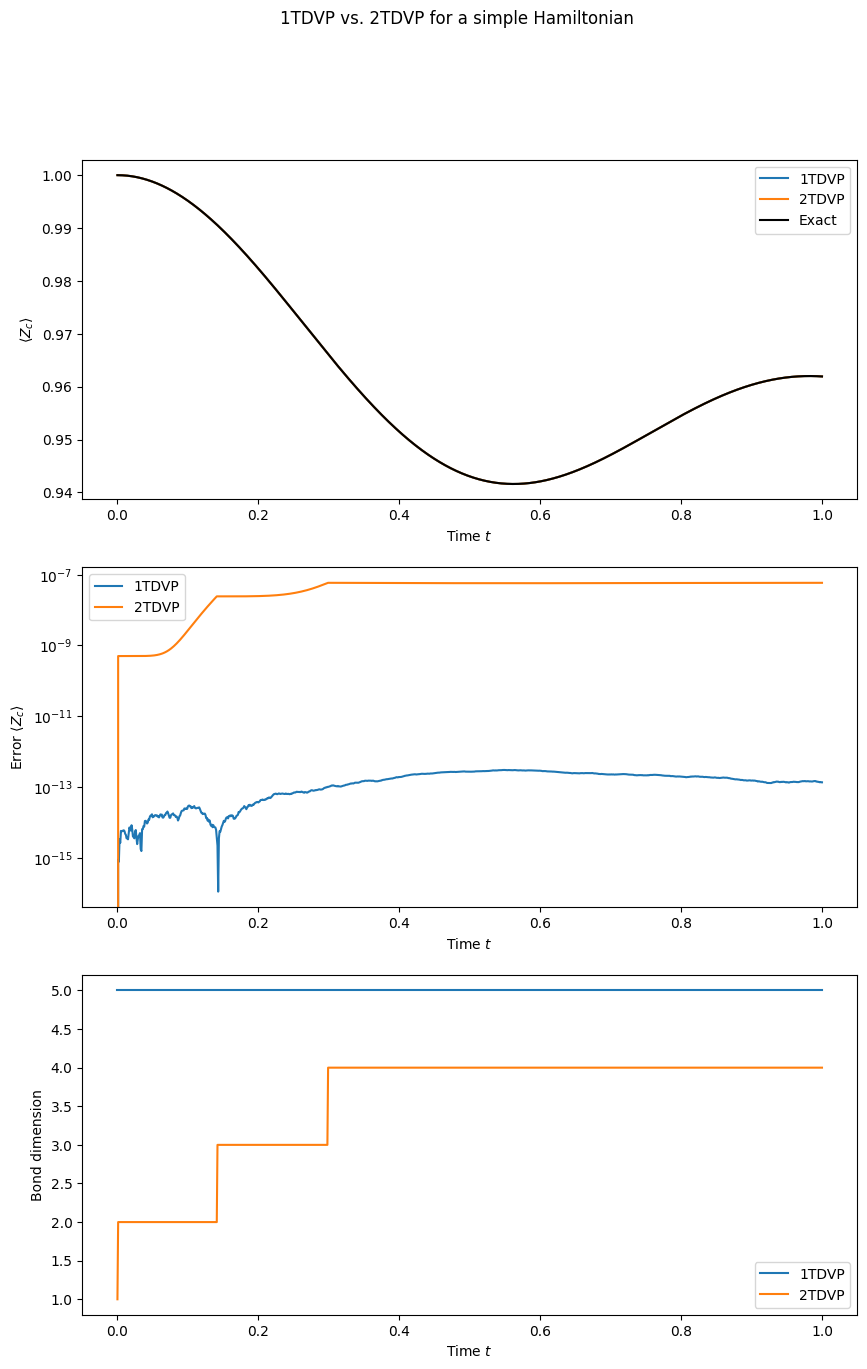

In [ ]:
fig_bd, ax_bd = plt.subplots(3,1, figsize=(10,15))

fig_bd.suptitle("1TDVP vs. 2TDVP for a simple Hamiltonian")

ax_bd[0].plot(times, tdvp1_result_center, label="1TDVP")
ax_bd[0].plot(times, tdvp2_result_center, label="2TDVP")
ax_bd[0].plot(times, exact_result_center, label="Exact", color="black")
ax_bd[0].set_xlabel("Time $t$")
ax_bd[0].set_ylabel(r"$\langle Z_c \rangle$")
ax_bd[0].legend()

ax_bd[1].semilogy(times, tdvp1_error, label="1TDVP")
ax_bd[1].semilogy(times, tdvp2_error, label="2TDVP")
ax_bd[1].set_xlabel("Time $t$")
ax_bd[1].set_ylabel(r"Error $\langle Z_c \rangle$")
ax_bd[1].legend()

ax_bd[2].plot(times, tdvp1_bond_dim, label="1TDVP")
ax_bd[2].plot(times, tdvp2_bond_dim, label="2TDVP")
ax_bd[2].set_xlabel("Time $t$")
ax_bd[2].set_ylabel("Bond dimension")
ax_bd[2].legend()

plt.show()

In [ ]:
tolerance = [10**(-i-1) for i in range(10)]
rel_tol_times = []
rel_tol_tdvps = []
for rel_tol in tqdm(tolerance):
    trunc_param = deepcopy(truncation_parameters)
    trunc_param["rel_tol"] = rel_tol
    trunc_param["total_tol"] = tolerance[-1]
    rel_tol_2tdvp = ptn.SecondOrderTwoSiteTDVP(ttns_trivial_bond_dim,
                                               hamiltonian,
                                               time_steps_size,
                                               final_time,
                                               operators,
                                               truncation_parameters=trunc_param,
                                               record_bond_dim=True
                                               )
    start = time()
    rel_tol_2tdvp.run(pgbar=False)
    end = time()
    rel_tol_times.append(end-start)
    rel_tol_tdvps.append(rel_tol_2tdvp)

  0%|          | 0/10 [00:00<?, ?it/s]


TypeError: 'SVDParameters' object does not support item assignment

In [ ]:
times = rel_tol_tdvps[0].times()
tdvp_rel_tol_results_center = [tdvp.operator_result("center", realise=True) for tdvp in rel_tol_tdvps]
tdvp_rel_tol_errors = [np.abs(tdvp_result - exact_result_center) for tdvp_result in tdvp_rel_tol_results_center]
tdvp_rel_tol_bond_dims = [tdvp.operator_result("bond_dim")[('center', 'chain_1')] for tdvp in rel_tol_tdvps]

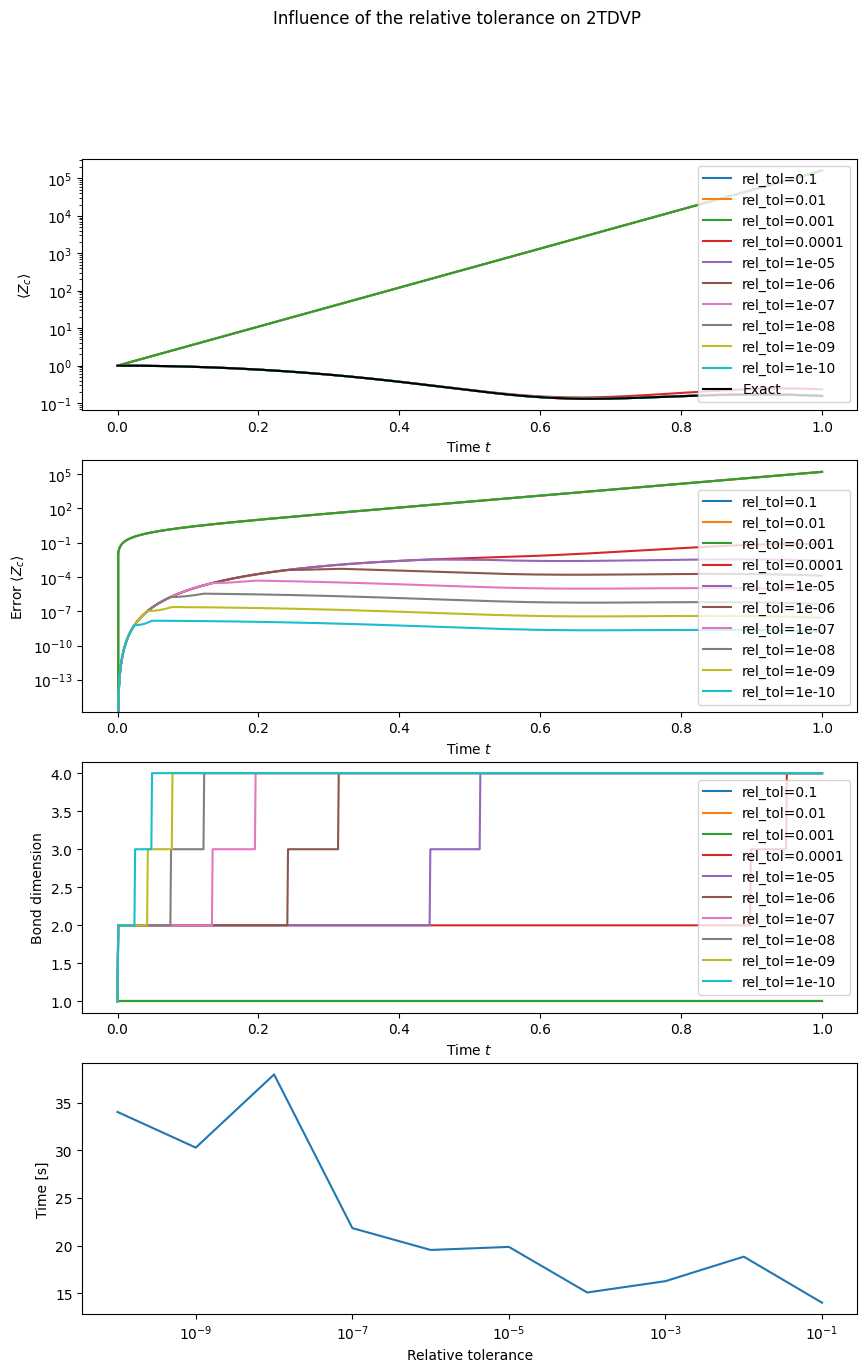

In [ ]:
fig_rel_tol, ax_rel_tol = plt.subplots(4,1, figsize=(10,15))

fig_rel_tol.suptitle("Influence of the relative tolerance on 2TDVP")

for i, rel_tol in enumerate(tolerance):
    ax_rel_tol[0].semilogy(times, tdvp_rel_tol_results_center[i], label=f"rel_tol={rel_tol}")

    ax_rel_tol[1].semilogy(times, tdvp_rel_tol_errors[i], label=f"rel_tol={rel_tol}")

    ax_rel_tol[2].plot(times, tdvp_rel_tol_bond_dims[i], label=f"rel_tol={rel_tol}")

ax_rel_tol[0].plot(times, exact_result_center, label="Exact", color="black")
ax_rel_tol[0].set_xlabel("Time $t$")
ax_rel_tol[0].set_ylabel(r"$\langle Z_c \rangle$")
ax_rel_tol[0].legend()

ax_rel_tol[1].set_xlabel("Time $t$")
ax_rel_tol[1].set_ylabel(r"Error $\langle Z_c \rangle$")
ax_rel_tol[1].legend()

ax_rel_tol[2].set_xlabel("Time $t$")
ax_rel_tol[2].set_ylabel("Bond dimension")
ax_rel_tol[2].legend()

ax_rel_tol[3].semilogx(tolerance, rel_tol_times)
ax_rel_tol[3].set_xlabel("Relative tolerance")
ax_rel_tol[3].set_ylabel("Time [s]")

plt.show()

In [ ]:
tolerance = [10**(-i-1) for i in range(10)]
abs_tol_tdvps = []
abs_tol_times = []
for abs_tol in tqdm(tolerance):
    trunc_param = deepcopy(truncation_parameters)
    trunc_param["rel_tol"] = tolerance[-1]
    trunc_param["total_tol"] = abs_tol
    abs_tol_2tdvp = ptn.SecondOrderTwoSiteTDVP(ttns_trivial_bond_dim,
                                               hamiltonian,
                                               time_steps_size,
                                               final_time,
                                               operators,
                                               truncation_parameters=trunc_param,
                                               record_bond_dim=True
                                               )
    start = time()
    abs_tol_2tdvp.run(pgbar=False)
    end = time()
    abs_tol_times.append(end-start)
    abs_tol_tdvps.append(abs_tol_2tdvp)

100%|██████████| 10/10 [04:24<00:00, 26.43s/it]


In [ ]:
times = abs_tol_tdvps[0].times()
tdvp_abs_tol_results_center = [tdvp.operator_result("center", realise=True) for tdvp in abs_tol_tdvps]
tdvp_abs_tol_errors = [np.abs(tdvp_result - exact_result_center) for tdvp_result in tdvp_abs_tol_results_center]
tdvp_abs_tol_bond_dims = [tdvp.operator_result("bond_dim")[('center', 'chain_1')] for tdvp in abs_tol_tdvps]

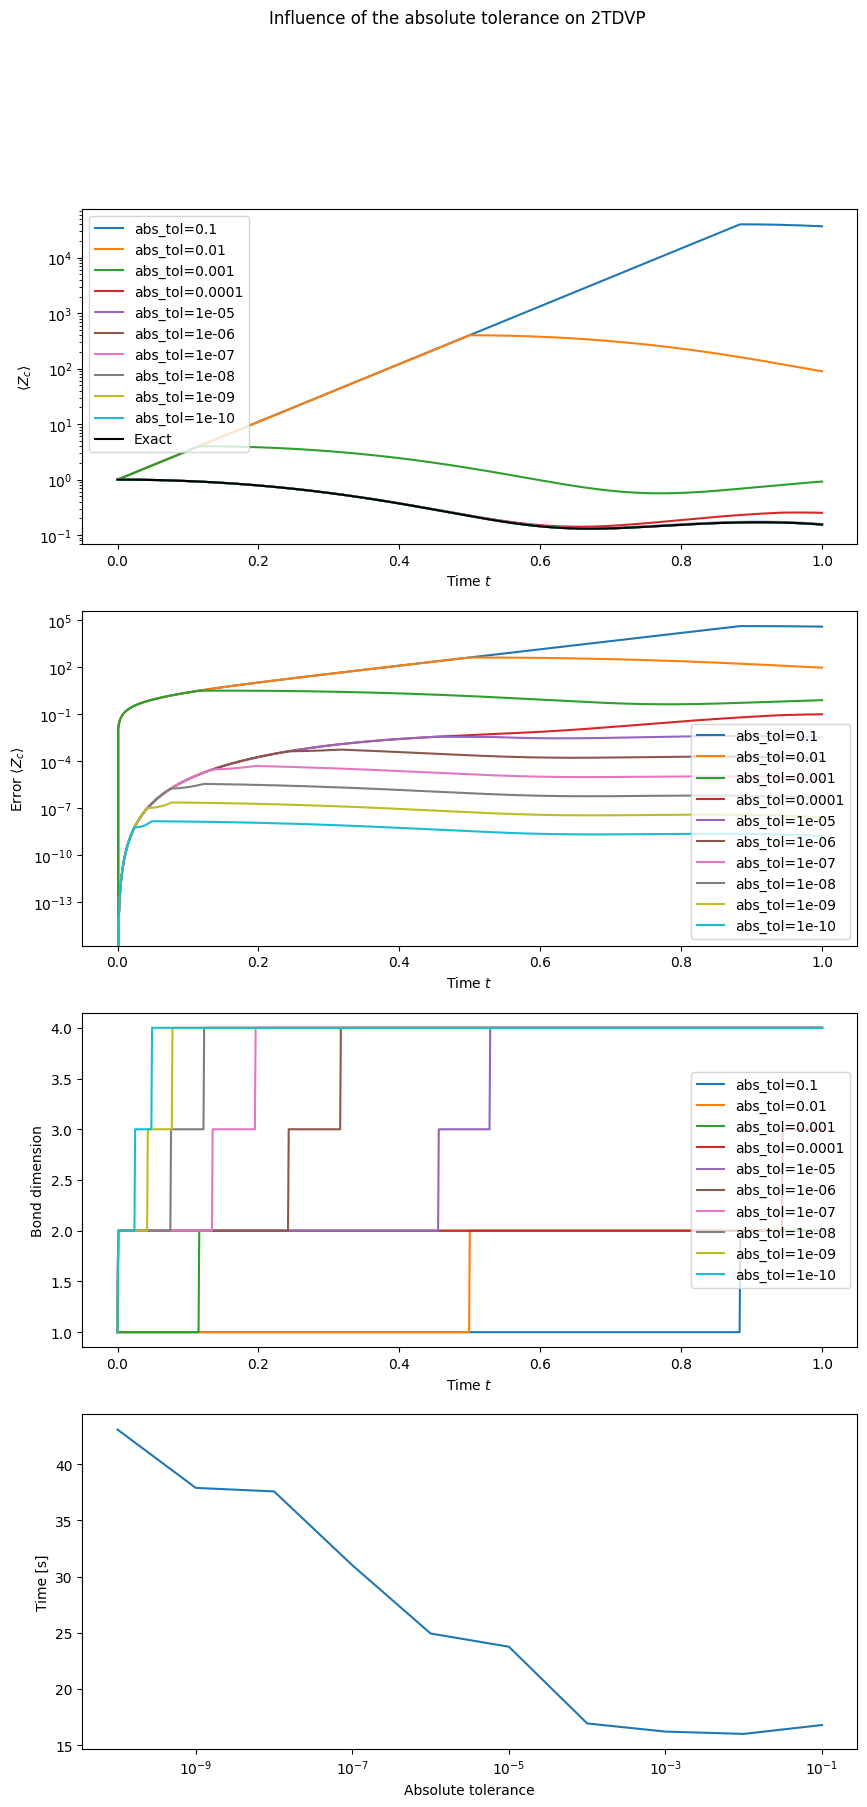

In [ ]:
fig_abs_tol, ax_abs_tol = plt.subplots(4,1, figsize=(10,20))

fig_abs_tol.suptitle("Influence of the absolute tolerance on 2TDVP")

for i, abs_tol in enumerate(tolerance):
    ax_abs_tol[0].semilogy(times, tdvp_abs_tol_results_center[i], label=f"abs_tol={abs_tol}")

    ax_abs_tol[1].semilogy(times, tdvp_abs_tol_errors[i], label=f"abs_tol={abs_tol}")

    ax_abs_tol[2].plot(times, tdvp_abs_tol_bond_dims[i], label=f"abs_tol={abs_tol}")

ax_abs_tol[0].plot(times, exact_result_center, label="Exact", color="black")
ax_abs_tol[0].set_xlabel("Time $t$")
ax_abs_tol[0].set_ylabel(r"$\langle Z_c \rangle$")
ax_abs_tol[0].legend()

ax_abs_tol[1].set_xlabel("Time $t$")
ax_abs_tol[1].set_ylabel(r"Error $\langle Z_c \rangle$")
ax_abs_tol[1].legend()

ax_abs_tol[2].set_xlabel("Time $t$")
ax_abs_tol[2].set_ylabel("Bond dimension")
ax_abs_tol[2].legend()

ax_abs_tol[3].semilogx(tolerance, abs_tol_times)
ax_abs_tol[3].set_xlabel("Absolute tolerance")
ax_abs_tol[3].set_ylabel("Time [s]")

plt.show()